In [ ]:
cd /content/drive/MyDrive/Colab_Notebooks/cv_project2

/content/drive/MyDrive/Colab_Notebooks/cv_project2


In [ ]:
import os
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
from tqdm import tqdm
from torch.nn.functional import relu
import torch.optim as optim
# Install torchmetrics
from collections import OrderedDict
ignore_index=250
%load_ext autoreload
%autoreload 2
os.makedirs("./figs/", exist_ok=True)
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode

In [ ]:
from skimage import io, transform
import numpy as np
import torch
from PIL import Image
import pandas as pd
import skimage.morphology

import matplotlib.patches as patches



In [ ]:
class CellsDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, csv_file_images, csv_file_masks):
        self.root_dir = root_dir
        # load all image files, sorting them to
        # ensure that they are aligned
        self.images = pd.read_csv(csv_file_images, header = None)
        self.masks = pd.read_csv(csv_file_masks, header = None)

    def __getitem__(self, idx):
        # load images and masks
        if torch.is_tensor(idx):
          idx = idx.tolist()
        img_name = os.path.join(self.root_dir, 'images/', str(self.images[0][idx]))
        mask_name = os.path.join(self.root_dir, 'masks/', str(self.masks[0][idx]))
        image = io.imread(img_name)
        image = image.astype(np.float32) #pytorch wants it to be float
        image = image- np.mean(image, axis=0) /  np.std(image, axis=0) #normalize

        mask = io.imread(mask_name)
        # Keep first channel only
        mask = mask[:,:,0]
        # Label independent connected components
        mask = skimage.morphology.label(mask)
        mask = mask.astype(np.float32)
        image = image[None, :] # add extra channels dimension
        mask = mask[None, :]

        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.nonzero(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            if xmin >= xmax:
              xmax = xmin + 1
            if ymin >= ymax:
              ymax = ymin + 1
            boxes.append([xmin, ymin, xmax, ymax])
        # convert everything into a torch.Ten sor
        image = torch.as_tensor(image, dtype = torch.float32)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones(num_objs, dtype=torch.int64)
        # masks[np.where(masks>0)] = 1 #make it binary (cell or background)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        if num_objs > 0:
          if len(boxes.shape) == 2 and boxes.shape[-1] == 4:
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
          else:
            print(num_objs, boxes.shape, idx)
            boxes = torch.zeros((num_objs, 4), dtype=torch.float32)
            area = torch.zeros((num_objs, 4), dtype=torch.float32)
        else:
          print(num_objs)
          boxes = torch.zeros((num_objs, 4), dtype=torch.float32)
          area = torch.zeros((num_objs, 4), dtype=torch.float32)

        image_id = torch.tensor([idx])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        return image, target

    def __len__(self):
        return len(self.images)

In [ ]:
train_dataset = CellsDataset(csv_file_images='/content/drive/MyDrive/Colab_Notebooks/cv_project2/csvs/train_images.csv',
                    csv_file_masks = '/content/drive/MyDrive/Colab_Notebooks/cv_project2/csvs/train_masks.csv',
                    root_dir='/content/drive/MyDrive/Colab_Notebooks/cv_project2/')
val_dataset = CellsDataset(csv_file_images='/content/drive/MyDrive/Colab_Notebooks/cv_project2/csvs/validate_images.csv',
                    csv_file_masks = '/content/drive/MyDrive/Colab_Notebooks/cv_project2/csvs/validate_masks.csv',
                    root_dir='/content/drive/MyDrive/Colab_Notebooks/cv_project2/')
test_dataset = CellsDataset(csv_file_images='/content/drive/MyDrive/Colab_Notebooks/cv_project2/csvs/test_images.csv',
                    csv_file_masks = '/content/drive/MyDrive/Colab_Notebooks/cv_project2/csvs/test_masks.csv',
                    root_dir='/content/drive/MyDrive/Colab_Notebooks/cv_project2/')

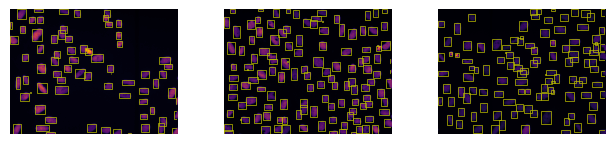

In [ ]:
fig = plt.figure()

for i, sample in enumerate(train_dataset):
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.axis('off')
    ax.imshow(sample[0].squeeze(), cmap = 'inferno')


    for j , coord in enumerate(sample[1]['boxes']):
      rect = patches.Rectangle((coord[0], coord[1]),  coord[2] - coord[0], coord[3] - coord[1],linewidth=0.5, edgecolor='y', facecolor='none')
      ax.add_patch(rect)

    if i == 2:
        plt.show()
        break


In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 42.7MB/s]


In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
from engine import train_one_epoch, evaluate
import utils


# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_val = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

# get the model using our helper function
# model = FasterRCNN(backbone,
#                 num_classes=2,
#                 rpn_anchor_generator=anchor_generator,
#                 box_roi_pool=roi_pooler)
# model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

# let's train it for 10 epochs
num_epochs = 20
loss = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    _, loss_item = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    loss.append(loss_item)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_val, device=device)
torch.save(model.state_dict(), "object_detection_last_epoch.pth")
print("That's it!")

Epoch: [0]  [ 0/50]  eta: 0:02:20  lr: 0.000107  loss: 1.0167 (1.0167)  loss_classifier: 0.2671 (0.2671)  loss_box_reg: 0.5259 (0.5259)  loss_objectness: 0.1162 (0.1162)  loss_rpn_box_reg: 0.1075 (0.1075)  time: 2.8157  data: 1.1037  max mem: 5283
Epoch: [0]  [10/50]  eta: 0:00:32  lr: 0.001126  loss: 1.0857 (1.0897)  loss_classifier: 0.2894 (0.2902)  loss_box_reg: 0.5253 (0.5137)  loss_objectness: 0.1553 (0.1541)  loss_rpn_box_reg: 0.1330 (0.1316)  time: 0.8088  data: 0.3096  max mem: 5708
0
Epoch: [0]  [20/50]  eta: 0:00:26  lr: 0.002146  loss: 1.1588 (1.1174)  loss_classifier: 0.3294 (0.3088)  loss_box_reg: 0.5234 (0.5090)  loss_objectness: 0.1593 (0.1609)  loss_rpn_box_reg: 0.1337 (0.1388)  time: 0.7746  data: 0.3593  max mem: 5715
0
Epoch: [0]  [30/50]  eta: 0:00:16  lr: 0.003165  loss: 1.1665 (1.1376)  loss_classifier: 0.3491 (0.3205)  loss_box_reg: 0.5222 (0.5102)  loss_objectness: 0.1672 (0.1639)  loss_rpn_box_reg: 0.1375 (0.1430)  time: 0.8287  data: 0.3992  max mem: 5735
Epoc

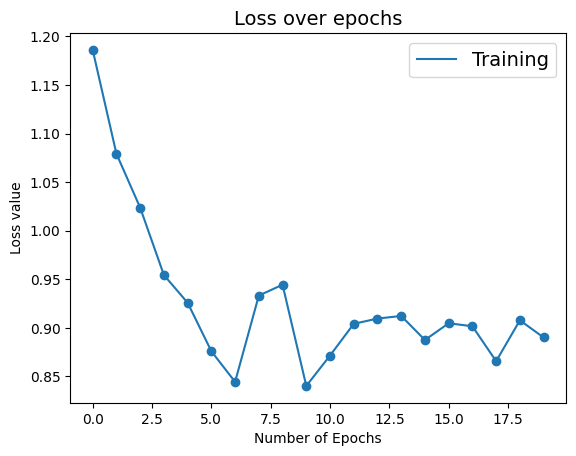

In [ ]:
x_axis = list(range(len(loss)))
plt.plot(loss , label="Training")
plt.scatter(x_axis, loss )
plt.ylabel('Loss value')
plt.xlabel('Number of Epochs')
plt.title("Loss over epochs", fontsize=14)
plt.legend(fontsize=14, loc='upper right')

In [ ]:
from engine import train_one_epoch, evaluate
import utils


# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_val = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)


# get the model using our helper function
model = FasterRCNN(backbone,
                num_classes=2,
                rpn_anchor_generator=anchor_generator,
                box_roi_pool=roi_pooler)
# model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)


In [ ]:

model.load_state_dict(torch.load("object_detection_last_epoch.pth"))


<All keys matched successfully>

torch.Size([100, 4])


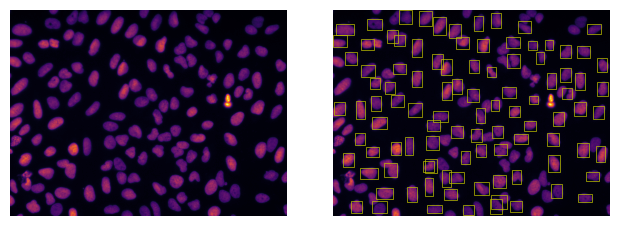

In [ ]:
model.eval()

imgs, targets = next(iter(data_loader_test))
images = list(image.to(device) for image in imgs)
preds = model(images)
print(preds[0]['boxes'].shape)
bb = torch.round(preds[0]['boxes'])

ax = plt.subplot(1, 2, 1)
plt.tight_layout()
ax.axis('off')
ax.imshow(images[0].cpu().detach().squeeze(), cmap = 'inferno')
ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.axis('off')
ax.imshow(torch.round(images[0].cpu().detach().squeeze()), cmap = 'inferno')
for j , coord in enumerate(bb.cpu().detach()):
    rect = patches.Rectangle((coord[0], coord[1]),  coord[2] - coord[0], coord[3] - coord[1],linewidth=0.5, edgecolor='y', facecolor='none')
    ax.add_patch(rect)

plt.show()


In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
data_loader = torch.utils.data.DataLoader(
 train_dataset, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=utils.collate_fn)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions